<a href="https://colab.research.google.com/github/albtad01/Porous-Matrix-Solver/blob/main/Porosita%CC%80_Solido_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test di Porosità per un Solido 2D

**Obiettivo:** Verificare se un solido modellato come matrice 2D è poroso, ossia se è possibile individuare un percorso di blocchi bianchi (in cui può passare un flusso d'acqua) che va dalla prima riga (entrata) all'ultima riga (uscita). <br /><br />
**Assunzioni:**

*   L'acqua può passare anche in diagonale (nei blocchi bianchi che lo consentono)
*   Sono ammessi più ingressi ed uscite
*   0= punto in cui può passare l'acqua
*   1= punto in cui **non** può passare l'acqua



## Struttura Dati Disjoint Set
Per risolvere il problema sfruttiamo una struttura dati basata sul Disjoint Set:

In [ ]:
%%writefile disjoint-set.h
#pragma once
#include <stdlib.h>

struct DisjointSet {

  /// parent
  unsigned *parent;

  /// rank
  unsigned *rank;

};

// Constructs a new set containing the given number of singleton sets.
// For example, init(3) --> {{0}, {1}, {2}}.
struct DisjointSet *init(unsigned n);

// Releases the memory for a disjoint-set data structure object. The argument
// can be NULL. Do not attempt to call free() on the pointer, because there may
// be internal structures and other implementation details. This function
// returns NULL to facilitate this code idiom: ds = destroy(ds);
struct DisjointSet *destroy(struct DisjointSet *ds);

// Finds set of given item x
unsigned find(struct DisjointSet *ds, unsigned x);

// Do union of two sets represented by x and y.
void Union(struct DisjointSet *ds, unsigned x, unsigned y);

// Tests whether the given two elements are members of the same set. Note that the arguments are orderless.
_Bool same_set(struct DisjointSet * ds, unsigned x, unsigned y);

Overwriting disjoint-set.h


## Codice

Il codice è stato fatto per una matrice NxM generica: per cambiare le dimensioni della matrice generata randomicamente è sufficiente cambiare le dimensioni di righe e colonne definite rispettivamente alle righe 7 e 8.

In [ ]:
%%writefile test_porosita.c

#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include "disjoint-set.h"
#define N 8 // number of rows
#define M 8 // number of columns
#define K N*M


struct DisjointSet *init(unsigned n);
struct DisjointSet *destroy(struct DisjointSet *ds);
unsigned find(struct DisjointSet *ds, unsigned x);
void Union(struct DisjointSet *ds, unsigned x, unsigned y);
_Bool same_set(struct DisjointSet * ds, unsigned x, unsigned y);

int main(){
    unsigned int i=0,j=0,t=0,en=0,ex=0,numPath=0;
    unsigned int S[N][M],v[K],enter[M],exit[M];

    /// Matrix Generation
    srand(time(NULL));
    for(i=0;i<N;i++){
      for(j=0;j<M;j++)
          S[i][j]=rand()%2;
    }


    /// Matrix Visualization: ASCII ART 1
    for(i=0;i<N;i++){
      for(j=0;j<M;j++)
        if(S[i][j]==0)
            printf("  ");
        else
            printf("\u2587\u2587");
        printf("\n");
    }
    printf("\n");

    /// ASCII ART 2
    for(i=0;i<N;i++){
      for(j=0;j<M;j++)
        printf("| %d ",S[i][j]);
        printf("|\n");
    }
    printf("\n");

    /// ASCII ART 3
    for(i=0;i<N;i++){
      for(j=0;j<M;j++)
        if(S[i][j]==0)
            printf(" . ");
        else
            printf(" X ");
        printf("\n");
    }

    /// From Matrix (2D) to Vector (1D)
    for(i=0;i<N;i++)
      for(j=0;j<M;j++)
        v[i*M+j]=S[i][j];

    /// Find the enter and the exit
    for(t=0;t<M;t++){
      if(v[t]==0){
        enter[en]=t;
        en++;
      }
    }
    for(t=K-M;t<K;t++){
      if(v[t]==0){
        exit[ex]=t;
        ex++;
      }
    }

    /// DisjointSet Application
    struct DisjointSet *obj=init(K);
    for(t=0;t<K-M;t++){
      if(v[t]==0){
        if((t+1)%M!=0 && v[t+1]==0){ // check right
            Union(obj,t,t+1);
        }
        if(t%M!=0 && v[t-1]==0){ // check left
            Union(obj,t,t-1);
        }
        if((t+M)<K && v[t+M]==0){ // check bottom
            Union(obj,t,t+M);
        }
        if((t + M + 1 < K) && (t+1)%M!=0 && v[t+M+1]==0){ // check bottom right
            Union(obj,t,t+M+1);
        }
        if( (t + M - 1 < K) && (t%M!=0) && v[t+M-1]==0){ // check bottom left
            Union(obj,t,t+M-1);
        }
      }
    }

    /// Final check
    for(i=0;i<en;i++){
      for(j=0;j<ex;j++){
        if(same_set(obj,enter[i],exit[j])){
          numPath++;
        }
      }
    }
    printf("\n");
    if(numPath==0)
      printf("La matrice non è porosa");
    else
      printf("La matrice è porosa");
    return 0;
}

/// Funzioni caratteristiche DisjointSet

// Constructs a new set containing the given number of singleton sets.
// For example, init(3) --> {{0}, {1}, {2}}.
struct DisjointSet *init(unsigned n) {
    struct DisjointSet *res = malloc(sizeof(struct DisjointSet));
    res->parent = malloc(n * sizeof(unsigned));
    res->rank = malloc(n * sizeof(unsigned));
    for (int i = 0; i < n; i++) {
        res->parent[i] = i;
        res->rank[i] = 1;
    }
    return res;
}

// Finds set of given item x
unsigned find(struct DisjointSet *ds, unsigned x) {
  // Finds the representative of the set
  // that x is an element of
  if (ds->parent[x] != x) {

      // if x is not the parent of itself
      // Then x is not the representative of
      // his set,
      ds->parent[x] = find(ds, ds->parent[x]);

      // so we recursively call Find on its parent
      // and move i's node directly under the
      // representative of this set
  }

  return ds->parent[x];
}

// Do union of two sets represented by x and y.
void Union(struct DisjointSet *ds, unsigned x, unsigned y){
    // Find current sets of x and y
    unsigned xset = find(ds, x);
    unsigned yset = find(ds, y);

    // If they are already in same set
    if (xset == yset) {
        return;
    }

    // Put smaller ranked item under
    // bigger ranked item if ranks are
    // different
    if (ds->rank[xset] < ds->rank[yset]) {
        ds->parent[xset] = yset;
    }
    else if (ds->rank[xset] > ds->rank[yset]) {
        ds->parent[yset] = xset;
    }
    else {
        // If ranks are same, then increment
        // rank.
        ds->parent[yset] = xset;
        ds->rank[xset] = ds->rank[xset] + 1;
    }
}

// Tests whether the given two elements are members of the same set. Note that the arguments are orderless.
_Bool same_set(struct DisjointSet * ds, unsigned x, unsigned y) {
    return find(ds, x) == find(ds, y);}

Overwriting test_porosita.c


## Compilazione ed Esecuzione

In [ ]:
!clang test_porosita.c -O2  -o test_porosita -g

In [ ]:
! ./test_porosita

  ▇▇  ▇▇▇▇▇▇  ▇▇
  ▇▇        ▇▇▇▇
▇▇  ▇▇▇▇▇▇▇▇  ▇▇
  ▇▇▇▇▇▇▇▇    ▇▇
▇▇      ▇▇  ▇▇  
▇▇▇▇  ▇▇▇▇▇▇  ▇▇
▇▇      ▇▇▇▇▇▇  
    ▇▇▇▇  ▇▇▇▇  

| 0 | 1 | 0 | 1 | 1 | 1 | 0 | 1 |
| 0 | 1 | 0 | 0 | 0 | 0 | 1 | 1 |
| 1 | 0 | 1 | 1 | 1 | 1 | 0 | 1 |
| 0 | 1 | 1 | 1 | 1 | 0 | 0 | 1 |
| 1 | 0 | 0 | 0 | 1 | 0 | 1 | 0 |
| 1 | 1 | 0 | 1 | 1 | 1 | 0 | 1 |
| 1 | 0 | 0 | 0 | 1 | 1 | 1 | 0 |
| 0 | 0 | 1 | 1 | 0 | 1 | 1 | 0 |

 .  X  .  X  X  X  .  X 
 .  X  .  .  .  .  X  X 
 X  .  X  X  X  X  .  X 
 .  X  X  X  X  .  .  X 
 X  .  .  .  X  .  X  . 
 X  X  .  X  X  X  .  X 
 X  .  .  .  X  X  X  . 
 .  .  X  X  .  X  X  . 

La matrice è porosa

## ASCII Art
Per la "Matrix Visualization" sono stati forniti 3 esempi di visualizzazione; per visualizzarli è sufficiente eseguire il codice precedente: per ogni matrice generata randomicamente verranno visualizzate le 3 rappresentazioni.

**ASCII Art 1** *(Riga 30-Riga 38)*<br />
Nel primo esempio di visualizzazione sono stati utilizzati due spazi ("  ") per indicare le celle con il numero 0 e due quadrati neri pieni ("▇▇"), codificati attraverso il codice unicode "\u2587", per indicare il numero 1. <br />

**ASCII Art 2** *(Riga 41-Riga 47)*<br />
In questo caso sono stati lasciati i numeri 0 e 1, separati ordinatamente attraverso un "|", al fine di separare in modo chiaro i numeri all'interno della matrice.
Si noti che in questo caso non sono stati utilizzati if/else. <br />

**ASCII Art 3** *(Riga 49-Riga 57)*<br />
In questo caso sono stati utilizzati dei punti "." per gli zeri e delle X per i numeri 1.

<br />
Questi sono solo alcuni dei modi per poter rappresentare una matrice, ma ne esistono infiniti, in quanto basta scegliere un carattere (o un set di caratteri) per quando la matrice assume il valore 0, e un altro carattere (o un altro set di caratteri) per quando la matrice assume il valore 1.
<br />

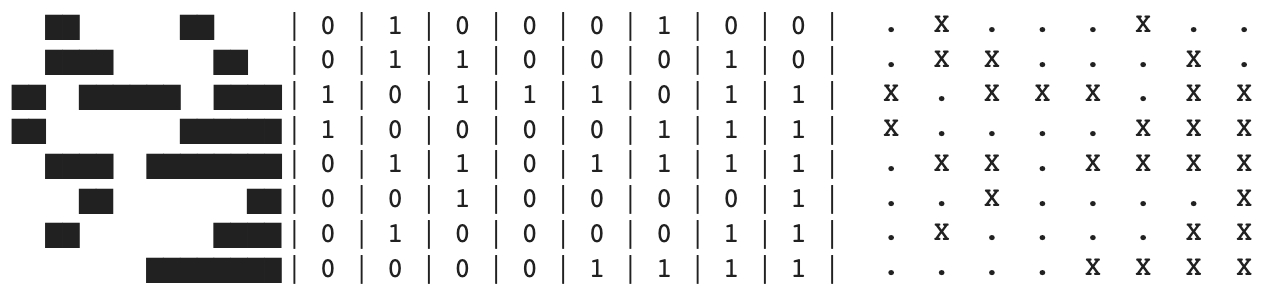

## Acqua passa in diagonale vs Acqua NON passa in diagonale

**CASO 1: L'acqua passa in diagonale**<br />
Un interessante spunto da prendere in analisi è l'assunzione fatta all'inizio, ossia di far sì che l'**acqua** possa passare tra i blocchi che lo consentono **in diagonale**.
Generando randomicamente la matrice ed eseguendo il codice più volte si può osservare come nella **maggior parte dei casi** il **test** di **porosità** esca **positivo**.
Ciò è dovuto al fatto che l'acqua può passare in tanti modi diversi all'interno del solido: a destra, a sinistra, in basso, in basso a destra, in basso a sinistra, e questo facilita il passaggio d'acqua all'interno del solido. <br />
Prendendo in analisi **100 matrici** 2D generate randomicamente, soltanto 14 sono risultate non porose, mentre le restanti 86 sono risultate porose; **dal nostro campione** si denota quindi che:<br />
* **86%** delle **matrici** sono **porose**; <br />
* **14%** delle **matrici** sono **non porose**;<br />

**CASO 2: L'acqua non passa in diagonale**<br />
Cosa succede allora se assumiamo invece che l'acqua non possa passare in diagonale? <br />
Per analizzare questo caso è sufficiente scartare dalle direzioni di scorrimento dell'acqua all'interno della matrice le direzioni basso-sinistra e basso-destra, ossia eliminare il codice dalla riga 91 alla riga 96. <br />
Analogamente al caso precedente, prendiamo in analisi altre 100 matrici 2D generate randomicamente ed effettuiamo nuovamente il test di porosità. Così facendo 15 matrici sono risultate porose, mentre le restanti 85 sono risultate non porose; **dal nostro campione** si denota quindi che: <br />
* **15%** delle **matrici** sono **porose**; <br />
* **85%** delle **matrici** sono **non porose**; <br />

Osserviamo un netto ribaltamento dei risultati, in quanto nel caso 2 l'acqua passerà con più difficoltà, in quanto ha meno direzioni da cui passare.

**N.B.:** Il campionamento di 100 matrici è ridotto: per avere una stima più accurata della % di matrici porose (e non) dovremmo prendere in analisi molte più matrici, ma in questa prima analisi si evincono già quali potrebbero essere i risultati di un campionamento di matrici più elevato.

